In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from torch.backends import cudnn
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
from qml.dataset import StockGANDataset
from datetime import datetime, timezone
from typing import Union, Literal
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
DATASET_DIR = "../../datasets"

SLIDING_WINDOW = 3
TICKERS = [
    "AAPL", # Apple
    "AMD",  # Advanced Micro Devices
    "AMZN", # Amazon
    "COST", # Costco
    "GOOG", # Google
    "INTC", # Intel
    "META", # Meta (Facebook)
    "NFLX", # Netflix
    "NVDA", # Nvidia
    "TSM",  # TSMC
    "YM=F", # Dow Jones Index
    "^NDX", # Nasdaq Index
    "^SPX", # Standard & Poor 500 Index
    "TSLA", # Tesla
]
TARGET = "AAPL"

## Data Preprocessing and Exploratory Data Analysis (EDA)

### Loading the data from Yahoo Finance

I wrote a `StockGANDataset` class to accomplish this since it is required to write a custom class that implements `torch.utils.data.Dataset` to use PyTorch's `DataLoader` utility later for handling training and test data.

In [3]:
dataset = StockGANDataset(
    tickers=TICKERS,
    target_ticker=TARGET,
    start=datetime(year=2014, month=1, day=1, tzinfo=timezone.utc),
    end=datetime(year=2024, month=1, day=1, tzinfo=timezone.utc),
    interval="1d",
    sliding_window=SLIDING_WINDOW,
    train_test_pct=(0.8, 0.2),
    root=DATASET_DIR
)

In [4]:
print(f"First 5 daily price for {TICKERS[0]}")
dataset.tickers[0].head()

First 5 daily price for AAPL


timestamp,open,high,low,close,volume
"datetime[ns, America/New_York]",f64,f64,f64,f64,i64
2014-01-02 00:00:00 EST,17.376396,17.418611,17.261946,17.296656,234684800
2014-01-03 00:00:00 EST,17.288215,17.314481,16.899522,16.916721,392467600
2014-01-06 00:00:00 EST,16.806338,17.098716,16.685946,17.00897,412610800
2014-01-07 00:00:00 EST,17.021165,17.072448,16.821034,16.887327,317209200
2014-01-08 00:00:00 EST,16.848869,17.059945,16.845118,16.994278,258529600


In [5]:
print(f"Data description for {TICKERS[0]}")
dataset.tickers[0].describe()

Data description for AAPL


statistic,timestamp,open,high,low,close,volume
str,str,f64,f64,f64,f64,f64
"""count""","""2516""",2516.0,2516.0,2516.0,2516.0,2516.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0
"""mean""","""2018-12-30 23:…",75.825142,76.652821,75.048317,75.888208,1.3667e8
"""std""",null,56.603648,57.24242,56.012278,56.658817,8.4036e7
"""min""","""2014-01-02 00:…",15.484528,15.683095,15.433557,15.628378,2.40483e7
"""25%""","""2016-07-01 00:…",27.251343,27.408283,27.063626,27.198179,8.13852e7
"""50%""","""2019-01-02 00:…",46.079879,46.451131,45.682458,46.039425,1.121723e8
"""75%""","""2021-06-30 00:…",132.714527,133.868847,131.104334,132.478256,1.668256e8
"""max""","""2023-12-29 00:…",197.767647,199.365599,196.748941,197.857529,1.0655e9


### Plotting the closing price of each ticker

The plot presented below uses only the daily closing price from `2014-01-01` to `2024-01-01`.

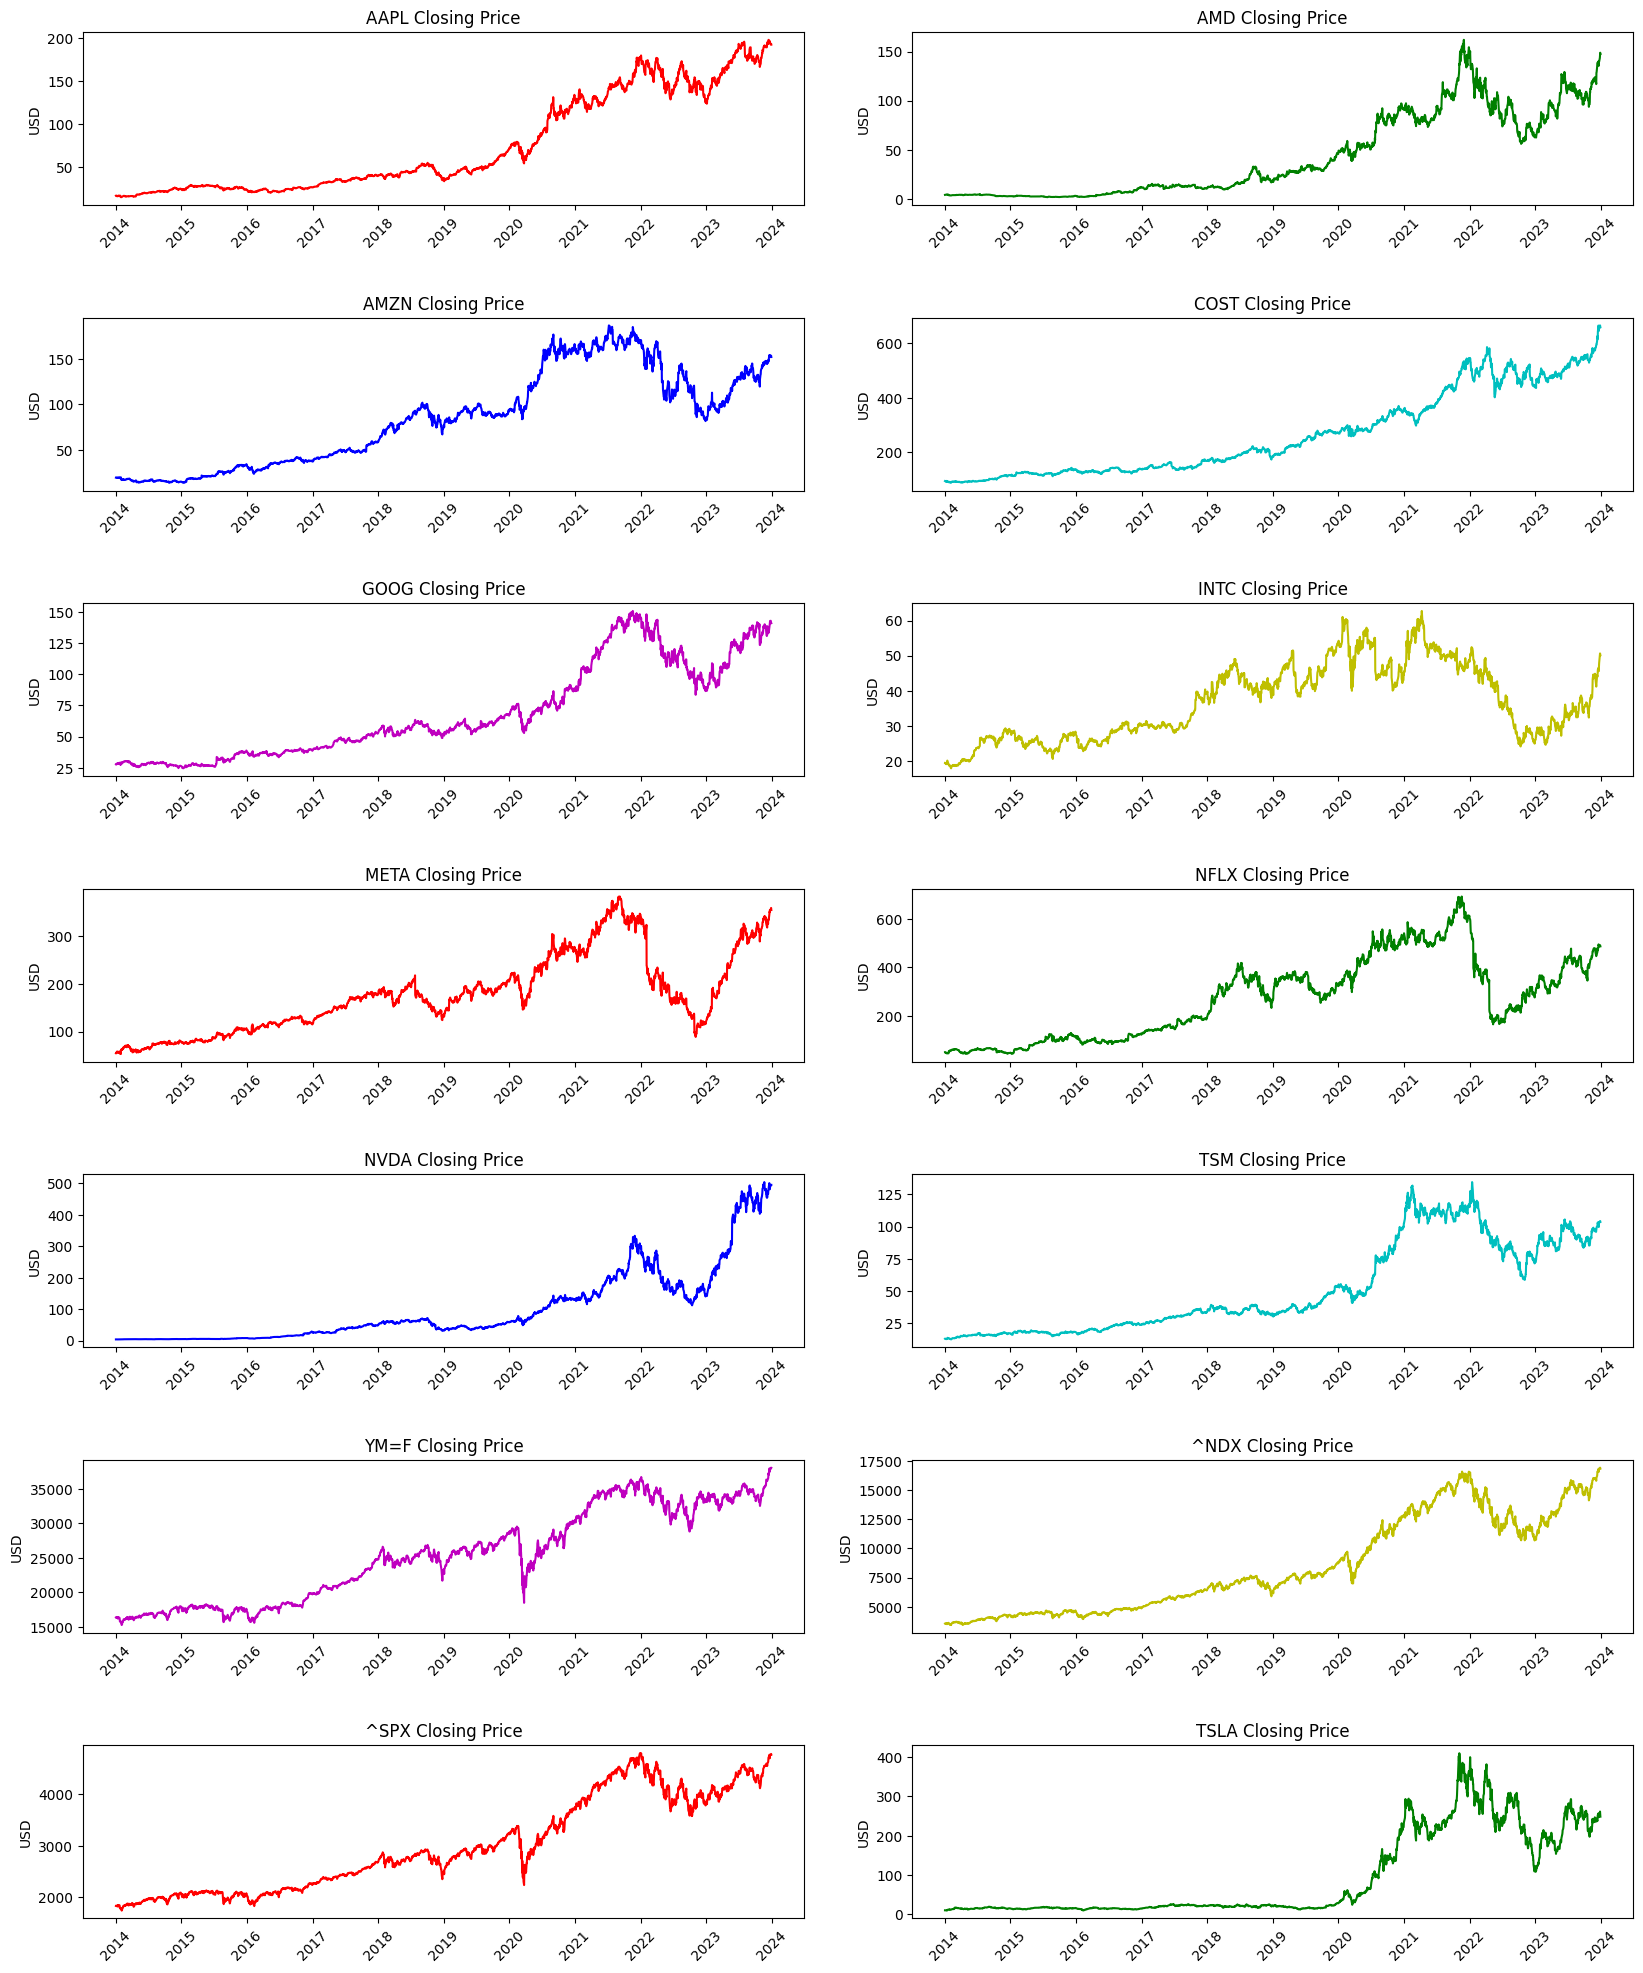

In [6]:
nrows = math.ceil(len(TICKERS) / 2)
fig, axs = plt.subplots(nrows, 2, figsize=(20, 3.5 * nrows))  
axs = axs.flat
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot the prices for each ticker
for i, (df, ticker) in enumerate(zip(dataset.tickers, dataset.ticker_names)):
    ax = axs[i]
    ax.plot(df["timestamp"], df["close"], label=ticker, color=mcolors.BASE_COLORS[colors[i % len(colors)]])
    ax.set(ylabel="USD", title=f"{ticker} Closing Price")
    ax.tick_params(axis='x', labelrotation=45)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.subplots_adjust(hspace=0.65, wspace=0.15)
plt.show()

### Aggregate all tickers into one dataframe

Since we only need the closing price of each ticker, we combine them into one dataframe indexed by the timestamp. This logic is implemented within the `StockGANDataset` class, we access it directly for inspection.

In [7]:
dataset.data.head()

timestamp,AAPL,AMD,AMZN,COST,GOOG,INTC,META,NFLX,NVDA,TSM,YM=F,^NDX,^SPX,TSLA
"datetime[ns, America/New_York]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2014-01-02 00:00:00 EST,17.296656,3.95,19.8985,94.780975,27.724083,19.378853,54.652012,51.831429,3.740547,12.816855,16388.0,3563.570068,1831.97998,10.006667
2014-01-03 00:00:00 EST,16.916721,4.0,19.822001,94.36261,27.521841,19.371332,54.502174,51.871429,3.695736,12.667385,16407.0,3538.72998,1831.369995,9.970667
2014-01-06 00:00:00 EST,17.00897,4.13,19.681499,93.646591,27.828691,19.130884,57.139374,51.367142,3.745264,12.63002,16365.0,3526.959961,1826.77002,9.8
2014-01-07 00:00:00 EST,16.887327,4.18,19.901501,93.212151,28.365179,19.228567,57.858608,48.5,3.806584,12.637491,16454.0,3557.850098,1837.880005,9.957333
2014-01-08 00:00:00 EST,16.994278,4.18,20.096001,91.755974,28.42421,19.108345,58.168282,48.712856,3.858471,12.772014,16407.0,3567.540039,1837.48999,10.085333


In [8]:
dataset.data.describe()

statistic,timestamp,AAPL,AMD,AMZN,COST,GOOG,INTC,META,NFLX,NVDA,TSM,YM=F,^NDX,^SPX,TSLA
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2514""",2514.0,2514.0,2514.0,2514.0,2514.0,2514.0,2514.0,2514.0,2514.0,2514.0,2514.0,2514.0,2514.0,2514.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2018-12-31 14:…",75.927887,43.143659,84.441976,265.786719,69.066382,36.637811,177.98284,274.618632,100.451955,51.538383,25316.174778,8494.5753,3006.552852,94.137001
"""std""",null,56.663873,42.266307,51.403256,152.693253,37.303839,10.632876,81.098705,165.903197,117.98158,34.391596,6603.440438,4024.957124,901.383512,108.519339
"""min""","""2014-01-02 00:…",15.628378,1.62,14.3475,88.642456,24.56007,17.841682,53.473263,44.887142,3.622622,12.301188,15292.0,3440.5,1741.890015,9.289333
"""25%""","""2016-06-30 00:…",27.200722,5.1,36.336498,132.802887,37.580502,27.416594,115.277687,110.099998,11.677112,21.391747,18078.539062,4672.109863,2124.199951,15.824667
"""50%""","""2019-01-03 00:…",46.067326,23.709999,86.925003,209.389374,56.966,35.469059,170.099518,288.299988,51.979435,36.026196,25325.0,7280.700195,2798.360107,21.882668
"""75%""","""2021-07-01 00:…",132.499374,82.010002,127.129997,382.519104,100.739998,45.334667,219.946625,384.799988,145.839874,84.804878,32007.0,12251.320312,3908.189941,200.839996
"""max""","""2023-12-29 00:…",197.857529,161.910004,186.570496,665.821228,150.709,62.730942,381.774933,691.690002,504.022034,134.516434,38029.0,16906.800781,4796.560059,409.970001


### Min-max normalisation

This is already being done in the `StockGANDataset` class.

### Network Setup

To construct a Generative Adversarial Network (GAN), we need two neural networks, the **Generator** and the **Discriminator**.

### Generator

In [9]:
class Generator(nn.Module):
    def __init__(
        self, 
        input_size: int, 
        device: Union[Literal["cuda"], Literal["cpu"]]
    ):
        super().__init__()
        self.device = device
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=1024, batch_first=True)
        self.gru2 = nn.GRU(input_size=1024, hidden_size=512, batch_first=True)
        self.gru3 = nn.GRU(input_size=512, hidden_size=256, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x: Tensor):
        h0 = torch.zeros(1, x.size(0), 1024).to(self.device)
        out1, _ = self.gru1(x, h0)
        out1 = self.dropout(out1)
        h1 = torch.zeros(1, x.size(0), 512).to(self.device)
        out2, _ = self.gru2(out1, h1)
        out2 = self.dropout(out2)
        h2 = torch.zeros(1, x.size(0), 256).to(self.device)
        out3, _ = self.gru3(out2, h2)
        out3 = self.dropout(out3)
        out4 = self.fc1(out3[:, -1, :])
        out5 = self.fc2(out4)
        out = self.fc3(out5)
        return out


### Discriminator



In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: Tensor):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3: Tensor = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

## Training

### Setup the training device 

Use CUDA (Nvidia GPU) if available otherwise CPU.

In [11]:
CUDA = torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.2.0


### Training parameters

A seed is manully set here to ensure repoducibility so that every time the model is trained with the same parameter, equivalent performance can be expected.

In [12]:
torch.manual_seed(1337)

BATCH_SIZE = 128
LEARNING_RATE = 0.00016
EPOCHS = 165

In [13]:
generator = Generator(input_size=len(TICKERS), device=device).to(device)
discriminator = Discriminator(input_size=SLIDING_WINDOW + 1).to(device)

loss = nn.BCELoss() 
g_optim = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
d_optim = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE)

g_losses = np.zeros(EPOCHS)
d_losses = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    g_local_losses = []
    d_local_losses = []

    # Get next batch of data from the dataloder
    for (x, y) in dataloader:
        x = x.to(device)
        y = y.to(device)

        # Generate fake data
        fake_data = generator(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        # Train the discriminator to understand true labels
        d_real_output = discriminator(y)
        real_labels = torch.ones_like(d_real_output).to(device)
        d_loss_real = loss(d_real_output, real_labels)

        # Train the discriminator to understand false label
        d_fake_output = discriminator(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        d_loss_fake = loss(d_fake_output, fake_labels)

        # Optimise the discriminator loss
        d_loss = (d_loss_real + d_loss_fake)
        discriminator.zero_grad()
        d_loss.backward(retain_graph=True)
        d_optim.step()
        d_local_losses.append(d_loss.item())

        # Optimise the generator loss
        d_fake_output = discriminator(fake_data)
        g_loss = loss(d_fake_output, real_labels)
        generator.zero_grad()
        g_loss.backward()
        g_optim.step()
        g_local_losses.append(g_loss.item()) 

    g_losses[epoch] = sum(g_local_losses) 
    d_losses[epoch] = sum(d_local_losses)    
    print(f'[{epoch+1}/{EPOCHS}] d_loss: {sum(d_local_losses)} g_loss:{sum(g_local_losses)}')


[1/165] d_loss: 22.178789019584656 g_loss:11.058990836143494
[2/165] d_loss: 22.180641174316406 g_loss:11.090276062488556
[3/165] d_loss: 22.181267619132996 g_loss:11.092241883277893
[4/165] d_loss: 22.18087148666382 g_loss:11.090139210224152
[5/165] d_loss: 22.18072021007538 g_loss:11.090637505054474
[6/165] d_loss: 22.180604934692383 g_loss:11.091178715229034
[7/165] d_loss: 22.1805100440979 g_loss:11.091022610664368
[8/165] d_loss: 22.180486798286438 g_loss:11.091077268123627
[9/165] d_loss: 22.18033730983734 g_loss:11.091609954833984
[10/165] d_loss: 22.180283069610596 g_loss:11.091586470603943
[11/165] d_loss: 22.18007004261017 g_loss:11.092803657054901
[12/165] d_loss: 22.180070996284485 g_loss:11.09092926979065
[13/165] d_loss: 22.179993987083435 g_loss:11.092488586902618
[14/165] d_loss: 22.179759621620178 g_loss:11.091654300689697
[15/165] d_loss: 22.179702639579773 g_loss:11.093161880970001
[16/165] d_loss: 22.179388523101807 g_loss:11.093714475631714
[17/165] d_loss: 22.1787

## Model Evaluation

### Evaluate the training loss

In contrast with other machine learning approaches, the ideal scenario for GAN is not steadily converging to a certain value. In fact, the discriminator and generator should maintain a dynamic balance since they are competing against each other. Therefore, it is common to see flunctuations in the training loss as an indication of the ongoing tug-of-war between the discriminator and generator.

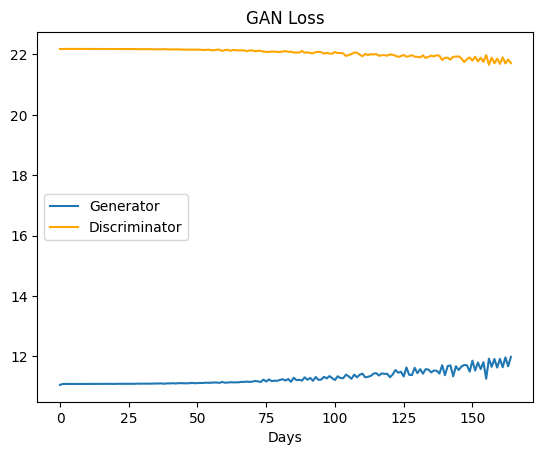

In [14]:
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator', color='orange')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc='center left')

### Evaluate the model on train and test data

Since this is not a classification problem, it does not make sense to measure the accuracy, F1-Score, etc. However, this problem is suitable to use regression metrics and I chose the following to evaluate the model performance.

- Root Mean Square Error (closer to $0.0$ is better)
- $R^2$ (coefficient of determination, closer to $1.0$ is better, can be negative)

In [15]:
generator.eval()
pred_y_train: Tensor = generator(dataset.train.g_in)
pred_y_test: Tensor = generator(dataset.test.g_in)

y_train_true = dataset.out_scaler.inverse_transform(dataset.train.g_out.reshape(-1, 1))
y_train_pred = dataset.out_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = dataset.out_scaler.inverse_transform(dataset.test.g_out.reshape(-1, 1))
y_test_pred = dataset.out_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset
RMSE: 5.148052339123236
R2: 0.9832403385051003


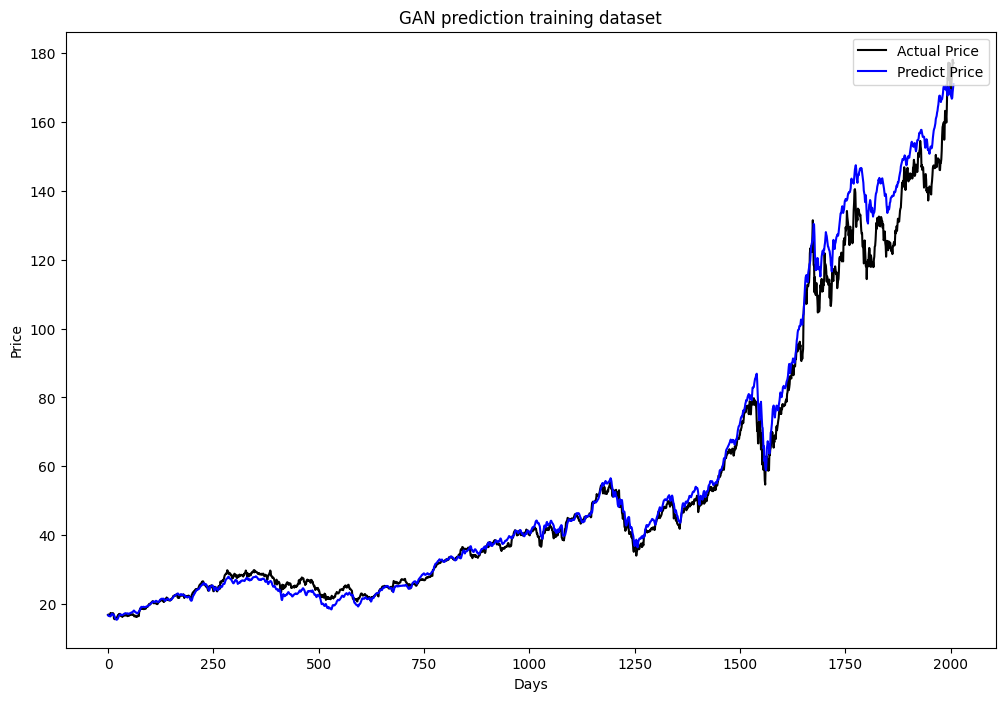

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_train_true, y_train_pred)
print(f'Training dataset\nRMSE: {RMSE}\nR2: {R2}')

Test dataset
RMSE: 10.901923382349697
R2: 0.6278975329829781


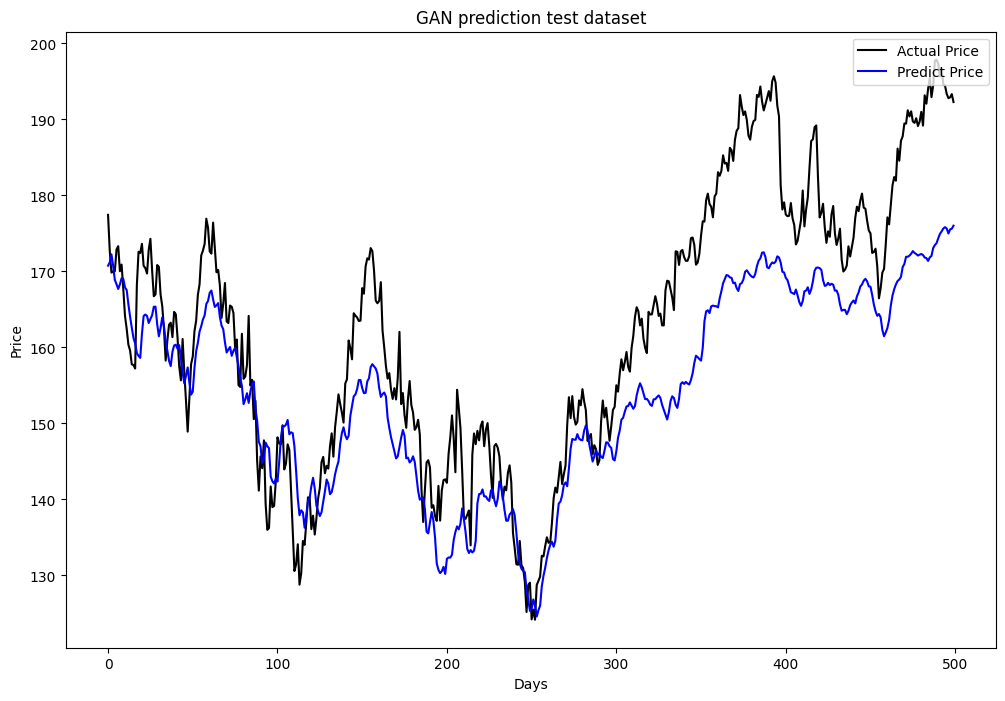

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Actual Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction test dataset')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test_true, y_test_pred)
print(f'Test dataset\nRMSE: {RMSE}\nR2: {R2}')